In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_breast_cancer

In [2]:
# For data preprocessing
cancer_data = pd.read_csv('./breast_cancer_bd.csv',sep=',')

device = torch.device('cpu')
cancer_data.iloc[cancer_data['Class'] == 4,-1] = 1
cancer_data.iloc[cancer_data['Class'] == 2,-1] = 0
# Set missed values to 1
cancer_data.iloc[cancer_data['Bare Nuclei'] == '?',-5] = 1
cancer_data.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


In [3]:
# Choose if keep the last feature
last_feature = True
if last_feature:
    features = 9
else:
    features = 8

X, y = cancer_data.iloc[:,1:features+1], cancer_data.iloc[:,-1]
X_normed = pd.DataFrame(MinMaxScaler().fit_transform(X))
X = X_normed.astype('float')
y = y.astype('float')
X = X.values
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.325, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

(699, 9)


In [4]:
print(X_train.shape)

torch.Size([471, 9])


In [5]:
class MLP(nn.Module):
    def __init__(self, features):
        super(MLP, self).__init__()
        self.features = features
        self.input_layer = nn.Linear(self.features, 11)  # 8/9 input neurons to 11 hidden neurons.
        self.hidden_layer = nn.Linear(11, 1)  # 11 hidden neurons to 1 output neuron
    
    def forward(self, x):
        x = torch.tanh(self.input_layer(x))  # Apply tanh activation to the input layer
        x = torch.sigmoid(self.hidden_layer(x))  # Apply sigmoid activation to the output layer for binary classification
        return x

In [6]:
# Initialize the model
model = MLP(features)
model = model.to(device)

criterion = nn.MSELoss()

#for name, param in model.named_parameters():
    #print(name, param)

# Define the optimizer (Adam optimizer).
optimizer = optim.Adam(model.parameters(), lr=0.1)


In [7]:
num_epochs = 44

for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    #print(loss)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  # Update weights
    
    #if (epoch + 1) % 1000 == 0:
       # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("Training completed")


Training completed


In [8]:
# Evaluate the model

with torch.no_grad():
    model.eval()
    predictions = model(X_test)
    predictions = (predictions > 0.5).float()
    accuracy = torch.sum(predictions.view(-1) == y_test).item() / y_test.size(0)
    print(f'Accuracy on test data: {accuracy:.4f}')



Accuracy on test data: 0.9649


#### Following is the Lev-Mar version (In thesis)

In [9]:
from torch.optim import Optimizer


def target_func(output):
    return criterion(outputs, y_train.view(-1, 1))

class LevenbergMarquardt(Optimizer):
    def __init__(self, params, lr=1, lambda_=0.01):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if lambda_ < 0.0:
            raise ValueError("Invalid lambda value: {}".format(lambda_))
        
        defaults = dict(lr=lr, lambda_=lambda_)
        super(LevenbergMarquardt, self).__init__(params, defaults)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
                
        for group in self.param_groups:
            for param in group['params']:
                if param.grad is None:
                    continue

                lr = group['lr']
                lambda_ = group['lambda_']
                if len(param.shape) == 2:
                    d_p = param.grad
                    d_p = torch.reshape(d_p, (-1,))
                    shape0, shape1 = param.shape[0],param.shape[1]
                    param = torch.reshape(param, (-1,))
                    # Compute the approximate Hessian matrix (second derivative)
                    approx_hessian = torch.autograd.functional.hessian(func=target_func,inputs=param,create_graph=True)
                    diag_values = torch.diag(approx_hessian) + lambda_
                    # Update parameters using LM formula: theta_new = theta - (H + lambda*I)^(-1) * gradient
                    update = torch.linalg.solve(approx_hessian + torch.diag(diag_values), -d_p)
                    param.data += lr * update
                    param = torch.reshape(param,(shape0,shape1))
                else:
                    d_p = param.grad
                    approx_hessian = torch.autograd.functional.hessian(func=target_func,inputs=param,create_graph=True)
                    diag_values = torch.diag(approx_hessian) + lambda_
                    # Update parameters using LM formula: theta_new = theta - (H + lambda*I)^(-1) * gradient
                    update = torch.linalg.solve(approx_hessian + torch.diag(diag_values), -d_p)
                    param.data += lr * update

        return loss

model = MLP(features)
lm_optimizer = LevenbergMarquardt(model.parameters(), lr=0.01, lambda_=0.001)
loss_list = []
num_epochs = 44
for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))      
    loss_list.append(loss.item())  
    lm_optimizer.zero_grad()
    loss.backward()
    lm_optimizer.step()
    if (epoch+1)%10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [10/44], Loss: 0.0271
Epoch [20/44], Loss: 0.0252
Epoch [30/44], Loss: 0.0242
Epoch [40/44], Loss: 0.0235


In [10]:
with torch.no_grad():
    model.eval()
    predictions = model(X_test)
    predictions = (predictions > 0.5).float()
    accuracy = torch.sum(predictions.view(-1) == y_test).item() / y_test.size(0)
    print(f'Accuracy on test data: {accuracy:.4f}')
    print('Correct:',torch.sum(predictions.view(-1) == y_test).item(),"Incorrect",y_test.size(0)-torch.sum(predictions.view(-1) == y_test).item())

Accuracy on test data: 0.9693
Correct: 221 Incorrect 7


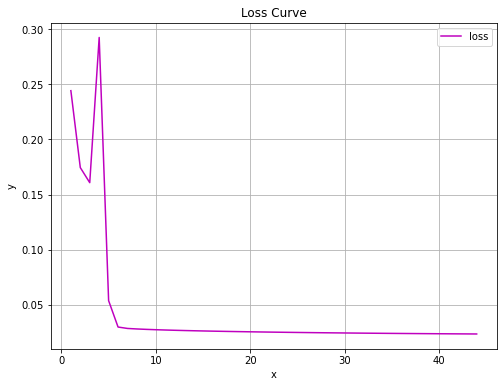

In [11]:
import matplotlib.pyplot as plt

x = np.linspace(1, len(loss_list) ,len(loss_list))
y = loss_list

plt.figure(figsize=(8, 6))
plt.plot(x, y, label='loss', color='m', linewidth=1.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()
